# Extract internal wave amplitude along the SWOT nadir track

In [1]:
# These are the sub-modules in the iwatlas package that we will use
from iwatlas import sshdriver
from iwatlas import harmonics


import xarray as xr
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt

/opt/tljh/user/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
basedir = '/data-obs/jupyter-ubuntu/iwatlas'
atlasfile = '{}/NWS_2km_GLORYS_hex_2013_2014_InternalWave_Atlas.nc'.format(basedir)

In [3]:
ssh = sshdriver.load_ssh_clim(atlasfile)
ssh

<xarray.Dataset>
Dimensions:     (Nc: 225368, numsides: 8, Np: 454016, Nmode: 4, Nk: 80, Nkw: 81, Nannual: 4, Nparams: 7, Ntide: 35)
Coordinates:
    xv          (Nc) float64 ...
    yv          (Nc) float64 ...
    Nk          (Nc) int32 74 76 76 75 73 74 77 76 ... 79 79 79 79 79 79 79 79
    z_w         (Nkw) float64 ...
    omegaA      (Nannual) float64 ...
    params      (Nparams) int64 ...
    omega       (Ntide) float64 ...
Dimensions without coordinates: Nc, numsides, Np, Nmode, Nkw, Nannual, Nparams, Ntide
Data variables: (12/15)
    cells       (Nc, numsides) int32 3058 3061 3060 2801 ... 316184 316187 -1 -1
    xp          (Np) float64 1.394e+07 1.271e+07 ... 1.303e+07 1.303e+07
    yp          (Np) float64 -1.619e+06 -2.553e+06 ... -2.056e+06 -2.055e+06
    nfaces      (Nc) int32 ...
    dv          (Nc) float64 ...
    modes       (Nmode) float64 ...
    ...          ...
    N2_re       (Nannual, Nparams, Nc) float64 ...
    N2_im       (Nannual, Nparams, Nc) float64 ...
 

In [4]:
# Load the SWOT nadir points

# swot = xr.open_dataset('/data-obs/jupyter-ubuntu/SWOT/SWOT_nadir_BrowseBasin_MarApr2023.nc')
# swot = xr.open_dataset('/data-obs/jupyter-ubuntu/SWOT/SWOT_nadir_BrowseBasin_MarJun2023.nc')
swot = xr.open_dataset('/data-obs/jupyter-ubuntu/SWOT/SWOT_nadir_BrowseBasin_MarJun2023_v2.nc')

swot

<xarray.Dataset>
Dimensions:                    (time: 2027)
Coordinates:
  * time                       (time) datetime64[ns] 2023-03-16T17:27:12.8417...
    longitude                  (time) float64 ...
    latitude                   (time) float64 ...
Data variables:
    longitude_theoretical      (time) float64 ...
    latitude_theoretical       (time) float64 ...
    distance_from_theoretical  (time) float64 ...
    cycle                      (time) float64 ...
    track                      (time) float64 ...
    sla_unfiltered             (time) float32 ...
    dac                        (time) float32 ...
    ib_lf                      (time) float32 ...
    ocean_tide                 (time) float32 ...
    internal_tide              (time) float32 ...
    mdt                        (time) float32 ...
    flag                       (time) float32 ...
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea Surface Height measured by altimeter...
    contact:                         aviso@altimetry.fr
    creator_email:                   aviso@altimetry.fr
    ...                              ...
    summary:                         SSALTO/DUACS Near-Real-Time Level-3 sea ...
    time_coverage_duration:          P23H51M44.812667S
    time_coverage_end:               2023-03-16T23:59:58Z
    time_coverage_resolution:        P1S
    time_coverage_start:             2023-03-16T00:08:13Z
    title:                           NRT SWOT nadir 1day Global Ocean Along t...

## Predict the SSH at all lon/lat/time points



In [5]:
aa, Aa, Ba, frq = sshdriver.extract_hc_ssh(ssh, swot.longitude.values, swot.latitude.values)
# Need to re-shape aa to get the shape right (this could be updated...)
ssh_it = sshdriver.predict_scalar(swot.time.values, aa.squeeze(), Aa, Ba, frq)
ssh_it.shape
# ssh_it = sshdriver.predict_ssh(ssh, swot.longitude.values, swot.latitude.values, swot.time.values)
# ssh_it

(2027,)

(array([19431., 19448., 19462., 19478., 19492., 19509., 19523.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

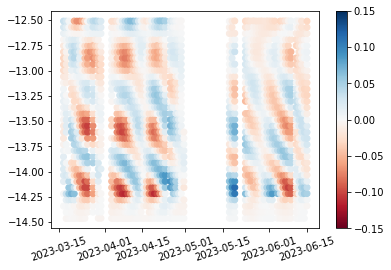

In [6]:
plt.figure()
plt.scatter(swot.time, swot.latitude, c=ssh_it, cmap='RdBu', vmin=-0.15, vmax=0.15)
plt.colorbar()
plt.xticks(rotation=18)

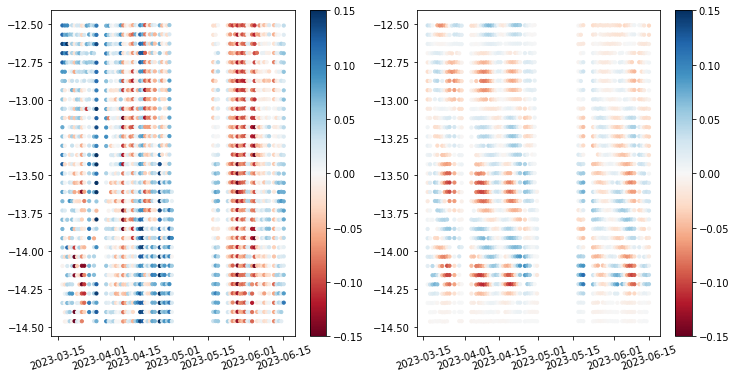

In [7]:
plt.figure(figsize=(12,6))
ax1=plt.subplot(121)
plt.scatter(swot.time, swot.latitude, \
        c=swot.sla_unfiltered - swot.sla_unfiltered.mean(), cmap='RdBu', vmin=-0.15, vmax=0.15,s=10)
plt.colorbar()
_=plt.xticks(rotation=18)

ax1=plt.subplot(122)
plt.scatter(swot.time, swot.latitude, c=ssh_it, cmap='RdBu', vmin=-0.15, vmax=0.15, s=10)
plt.colorbar()
_=plt.xticks(rotation=18)

In [8]:
dsout = xr.merge([swot, xr.DataArray(ssh_it, {'time':swot.time}, name='ssh_iwatlas')])
dsout

<xarray.Dataset>
Dimensions:                    (time: 2027)
Coordinates:
  * time                       (time) datetime64[ns] 2023-03-16T17:27:12.8417...
    longitude                  (time) float64 123.2 123.2 123.2 ... 123.4 123.4
    latitude                   (time) float64 -14.34 -14.22 ... -12.57 -12.51
Data variables: (12/13)
    longitude_theoretical      (time) float64 123.1 123.2 123.2 ... 123.4 123.4
    latitude_theoretical       (time) float64 -14.34 -14.22 ... -12.57 -12.51
    distance_from_theoretical  (time) float64 0.5697 0.5678 ... 0.5518 0.5502
    cycle                      (time) float64 461.0 461.0 461.0 ... 552.0 552.0
    track                      (time) float64 21.0 21.0 21.0 ... 21.0 21.0 21.0
    sla_unfiltered             (time) float32 0.171 0.126 0.127 ... 0.15 0.17
    ...                         ...
    ib_lf                      (time) float32 0.016 0.016 ... -0.016 -0.015
    ocean_tide                 (time) float32 -0.337 -0.338 ... 0.194 0.196
    internal_tide              (time) float32 0.0 0.0 0.0 ... -0.003 -0.004
    mdt                        (time) float32 1.005 1.008 1.01 ... 1.021 1.019
    flag                       (time) float32 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    ssh_iwatlas                (time) float64 0.0002649 0.003094 ... -0.03085
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea Surface Height measured by altimeter...
    contact:                         aviso@altimetry.fr
    creator_email:                   aviso@altimetry.fr
    ...                              ...
    summary:                         SSALTO/DUACS Near-Real-Time Level-3 sea ...
    time_coverage_duration:          P23H51M44.812667S
    time_coverage_end:               2023-03-16T23:59:58Z
    time_coverage_resolution:        P1S
    time_coverage_start:             2023-03-16T00:08:13Z
    title:                           NRT SWOT nadir 1day Global Ocean Along t...

In [9]:
# dsout.to_netcdf('/data-obs/jupyter-ubuntu/SWOT/SWOT_nadir_BrowseBasin_MarApr2023_w_iwatlas.nc')
dsout.to_netcdf('/data-obs/jupyter-ubuntu/SWOT/SWOT_nadir_BrowseBasin_MarJun2023_w_iwatlas_v2.nc')

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SerializationWarning: saving variable longitude with floating point data as an integer dtype without any _FillValue to use for NaNs
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SerializationWarning: saving variable latitude with floating point data as an integer dtype without any _FillValue to use for NaNs
  
